In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# BLIF - Bamford Leaky Integrate and Fire 

## Background

These models were created as part of my Masters at reading university. I had a huge interest in neural networks especially with piking neural networks as Deep Learning was not a huge field back then.

I want to try and apply some things I have learned while working with deep learning at import.io, to the models I had while in university. I also have several other ideas that i think I could apply, for example:

* Using sorted sets to store future spike events. 
  * This was previously done using a list of lists which stored the events up to 20 time points in the future. 
  * Can store a limitless number of events in a sorted set, where the item in the set is scored with a timestamp of **expected execution time**. Much like a CPU scheduler
* Implementing Error Backpropagation
  * Can work out how to propagate errors back to previous neurons based on error and time values, this is known as **Spike Time Dependent Plasticity**
  * Can implement some basic output layers such as softmax .
  * Can implement Error functions such as cross entropy, mean squared error etc..
  
  
Generally this is for pure interest and my own personal research. Also its good practice understanding mathematical concepts that come in hanny when doing any kind of ML project.

## BLIF

The BLIF neuron model (renamed from cavalcade because thats a bit shitty) is a spiking neuron model with a very basic activation function.

### Action potential

The neuron's activation potential is reactive to instantaneous spikes (To be more mathematically correct, it is effectively integrating a dirac delta). The neuron then exponentially decays that action potential ($V$) over time with respect to when that spike was recieved. 

$V(t) = \alpha.e^{-(t_{n} - t_{n-1}) \over \epsilon}$

($\epsilon$ here is a "decay factor")


For example: Given a spike $\alpha = 1$ a time $t = 0$ and there are no other spikes

$V(t) = \alpha.e^{-(t - 0) \over \epsilon}$

(<matplotlib.axes.AxesSubplot at 0x7fd4f70d7350>,
 <matplotlib.axes.AxesSubplot at 0x7fd4f705ce90>)

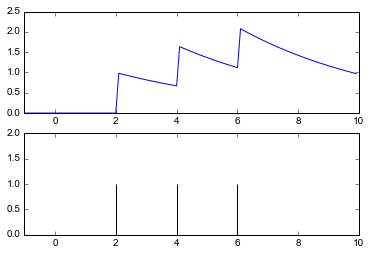

In [119]:
# Definte a function that will plot our action potential
def plot_BLIF(t, phi, A, epsilon):
    
    phi = np.array(phi)
    A = np.array(A)
    
    # Create integratons of diract delta functions for each spike
    D = np.tile(t, (len(phi), 1))
    cidx, ridx = np.where(D.T>=phi)
    D[:,:] = 0
    D[ridx, cidx] = 1
    
    # Decay function for each spike
    E = np.exp(-((t - phi[None,:].T) / epsilon))
    
    #print D
    #print alphas
    #print E

    # Multiply integrated spikes with spike strengths
    Da = np.multiply(D.T, A)

    #print Da
    
    #Vt = np.dot(Da, E)
    
    #print Da.T * E

    # Sum the product of the exponentials and the integrated dirac step
    Vt = np.sum(Da.T * E, axis=0)
    
    #print Vt

    fig = plt.figure()
    top = fig.add_subplot(211)
    bottom = fig.add_subplot(212)

    top.set_xlim([min, max])
    bottom.set_xlim([min, max])
    bottom.set_ylim([0, 2])

    top.plot(t, Vt.T)
    bottom.vlines(phi, [0], A)
    
    return (top, bottom)


epsilon = 5.0
min = -1.0
max = 10.0

t = np.arange(min, max, 0.1)

# One spike a t=0 with aplitude 1
ts = [2, 4, 6]
alphas = [1.0 , 1.0, 1.0]

plot_BLIF(t, ts, alphas, epsilon)

#### Multiple spikes

The action potential with many input spikes can be calculated by adding the spike amplitude to the current action potential and then decaying from that point.

For example: Given a spike $\alpha = 1$ a time $t = 0$ and there is a spike at $t=3$

$V(t)= \cases{
    \alpha.e^{-(t - 0) \over \epsilon} & \text{if } t\lt3\cr
    \alpha.e^{-(3 - 0) \over \epsilon} + \alpha.e^{-(t - 3) \over \epsilon} & \text{if } t\ge3
}$

(<matplotlib.axes.AxesSubplot at 0x7fd4f7534c10>,
 <matplotlib.axes.AxesSubplot at 0x7fd4f6f36150>)

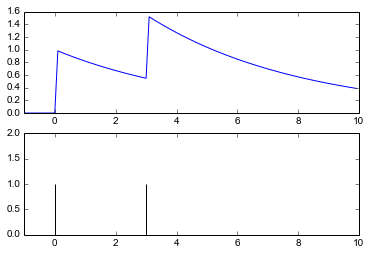

In [120]:
min = -1.0
max = 10.0

t = np.arange(min, max, 0.1)

plot_BLIF(t, [0, 3], [1, 1], 5)

#### Affect of spike trains on action potential

In the plot_BLIF function above we can use any combination of spike inputs and timing to generate our activation function. If we have a spikes at a frequency of $f = 1/t_{f}$, the action potential will look like this.

(<matplotlib.axes.AxesSubplot at 0x7fd4f6cd62d0>,
 <matplotlib.axes.AxesSubplot at 0x7fd4f6c6f690>)

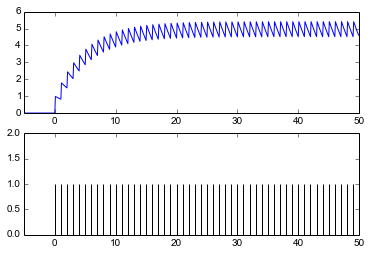

In [122]:
alpha = 1
tf = 1
epsilon = 5

# t = [1,2,3.....n]
min = -5.0
max = 50.0
t = np.arange(min, max, 0.1)

spike_timings = np.arange(0, max, tf)
spike_amplitudes = alpha * np.ones_like(spike_timings)

plot_BLIF(t, spike_timings, spike_amplitudes, epsilon)

At a fixed frequency, initially the action potential rises very fast, but tends to level off. This will be referred to as the saturation point of the neuron.


### Saturation 

Saturation ($\hat U$) is the peak value that the action potential will rise to and stay at over time. It can be shown that is follows a fairly simple geometric progression:

$\hat U = {\alpha \over {1-e^{t_{f} \over \epsilon}}}$ with respect to $t_{f}$

1.76386323658


ValueError: x and y must have same first dimension

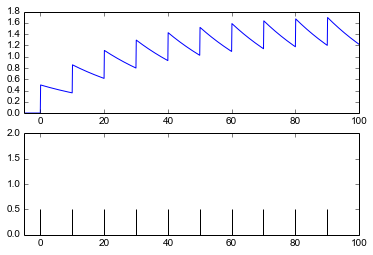

In [125]:
alpha = 0.5
tf = 10.0
epsilon = 30.0

min = -5.0
max = 100.0
t = np.arange(min, max, 0.1)

spike_timings = np.arange(0, max, tf)
spike_amplitudes = alpha * np.ones_like(spike_timings)

top, _ = plot_BLIF(t, spike_timings, spike_amplitudes, epsilon)


# now we can calculate Uhat and U
Uhat = alpha/(1-np.exp(-tf/epsilon)) 
#U = 
print Uhat

#Uhat_time = Uhat * np.ones_like(spike_timings)
top.plot(spike_timings, Uhat_time)


 
### Threshold firing
 * relationship between input frequency and output frequency
 * how do epsilon/alpha/firing frequency of two neurons affect the final neuron output saturation
 
## backward dynamics (ignoring spike timing dependence)
 * just using saturation, how would we change firing frequency or epsilon to get to a target
 * back propagation of simple XOR/classification etc

## backward dynamics (using spike timing dependence)
 * how do we use the spike timing of multiple neurons to backpropagate deltas at an event level?
 * are the output time dependent functions and we differentiate with respect to time? (can we train to generate a sine wave or something similar) would we need to 
 * can we use recurrent connections to learn output patterns?

In [45]:
a = np.zeros(100)


SyntaxError: invalid syntax (<ipython-input-45-1d21ab8ef298>, line 3)